# Understanding Resnets

In this post, we shall look at the Resnet Architecture introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). This paper was very influential in the deep learning world as nowadays, these residual networks have become a standard goto for many different kinds of tasks ranging across classification, regression, segmentation et al.

Here, we shall discuss the issue which resnets help solve and build one implementation of resnets (they come in multiple versions 18, 34, 50, 101 etc.) from scratch to have a look at how they could help stabilize the training and even learn better than plain convolutional neural networks.

- [The problem with plain deep CNNs]()
- [The idea behind resnet]()
- [The imagenette dataset]()
- [Building our own Resnet34 from scratch]()
- [Compare training graphs]()
- [Conclusion]()
- [References]()

# Drawbacks of plain CNNs

The paper mentions and it is also quite intuitive that with deepening the network, the learning process slows down. Why? Because in a plain network which is deep, the gradients which flow from the output layer back to the first layer becomes lower and lower in most cases. This could be attributed to the chain rule of derivatives and the fact that multiplication of numbers in the range [0-1] keeps reducing the magnitude of the product. The visual below should make this more clear.

![INSERT IMAGE HERE Chain Rule & error backpropagation](./images/backprop.jpeg)

Why are the derivatives small? This could be attributed to two reasons:

1. **Selection of activation function**:  Activation functions like `tanh` and `sigmoid` tend to saturate at the extremes and only give signal in a small range of values. So, their derivatives plateau out to sub-one magnitudes and the chain rule of multiplication will compound the effect of these activations more in case of deeper architectures.

2. **Nature of loss landscape**: As we start approaching any optimal point (local or global), the derivative of the objective function wrt weights will go on decreasing because the slope will start reducing. This will shrink the gradients and therefore the updates/penalization magnitude in earlier layers will be small due to the same reason as above.

![INSERT IMAGE HERE - Sigmoid derivatives & Loss landscape](./images/vanishing_gradients.jpeg)

In order for effective learning to happen, there should be a relatively decent error signal which backpropagates/penalizes the weights so that they optimize the objective function. There could be many ways to do this but one of the ideas which is presented in Resnets is this idea of skip connection. Consider the block below.

# The idea behind Resnet

![INSERT IMAGE HERE - Resblock](https://miro.medium.com/max/944/1*Cc3o7Hq7aMb0JPb9UuuxzA.png)

Now, in addition to a plain forward pass, we are adding a connection from a downstream component to an upstream component every fixed number of skips/layers (2 here). When we're going to update the weights therefore, we're gonna have two avenues/signals to penalize the weights to get them to the optimal state. One is the plain forward pass and one is this skip pass. This way the magnitude of signals that go into updating/penalizing these weights for the downstream task will be higher and the learning process will hence be more effective.

Two terms are commonly used when we describe the Resblock architecture above, they're as follows:

![INSERT IMAGE HERE - Residual connection & Skip Connection](./images/vanishing_gradients.jpeg)

- **Residual Connection** - This is the plain forward pass connection which is equivalent to had the resblock been a plain convolutional block.

- **Skip Connection** - This is the star contribution of the paper i.e. the connection from an input to several skips/layers down the block. This aids the learning process and helps mitigate the vanishing gradient problem substantially.

## Overlooked contribution of resnets

Another important contribution which resnets made that is often overlooked is making the downstream task resolution agnostic. In most previous works like VGG, Alexnet etc. the output of the CNNs was flattened and fed to an MLP/ fc layer directly. 

What this means is that the input must always be resized to a fixed dimension i.e. the dimension on which the architecture was trained. Also this flattening meant the number of parameters would be very high in the MLP stage and it would make our model heavy.

Resnets took a different approach. Before the flattening step, they took a global average pooling over the spatial dimension and then flattened and built an MLP on top of this. This made their architecture resolution agnostic. You could train on a high res image and infer on a low res one or vice versa or you could keep the resolution the same (Only condition is square resolution which is also the case for VGG/Alexnet). This should become clear with the snippet below.

![](./images/adaptive_architecture.jpeg)

In [1]:
from fastai.vision.all import *
c = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)

In [2]:
# Simulate a 224 x 224 input

i = torch.randn(1, 3, 224, 224)
op = c(i)
print(f"Convolution Output shape: {op.shape}")

vgg_output = Flatten()(op)
print(f"Output after plain flattening: {vgg_output.shape}")

resnet_output = Flatten()(torch.mean(op, dim = (2, 3)))
print(f"Output after pooling and flattening: {resnet_output.shape}")

Convolution Output shape: torch.Size([1, 64, 224, 224])
Output after plain flattening: torch.Size([1, 3211264])
Output after pooling and flattening: torch.Size([1, 64])


In [3]:
# Simulate a 460 x 460 input

i = torch.randn(1, 3, 460, 460)
op = c(i)
print(f"Convolution Output shape: {op.shape}")

vgg_output = Flatten()(op)
print(f"Output after plain flattening: {vgg_output.shape}")

resnet_output = Flatten()(torch.mean(op, dim = (2, 3)))
print(f"Output after pooling and flattening: {resnet_output.shape}")

Convolution Output shape: torch.Size([1, 64, 460, 460])
Output after plain flattening: torch.Size([1, 13542400])
Output after pooling and flattening: torch.Size([1, 64])


As seen from the above outputs, the plain flattening results change when we pass them through a conv layer whereas averaging across the spatial dimensions before flattening keeps the output shape intact.

This makes resnets more convenient and versatile than plain old vgg/alexnet that were and are good starting points but mandate the input to be in some sort of a fixed shape.

# The imagenette dataset

Fastai has provided an inbuilt dataset called imagenette which is a subset of ten classes from the imagenet challenge. Let's have a look at the dataset and get a high level understanding of it.

I have borrowed the class labels for imagenet [from here](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57).

In [4]:
# Download the dataset and print the path
path = untar_data(URLs.IMAGENETTE)
print(path.ls())

[Path('/home/vinayak/.fastai/data/imagenette2/val'), Path('/home/vinayak/.fastai/data/imagenette2/train'), Path('/home/vinayak/.fastai/data/imagenette2/noisy_imagenette.csv')]


In [5]:
labels = {x.split(" ")[0]: x.split(" ")[-1] for x in Path("./class_labels.txt").read_text().split("\n")}
def get_y(path):
    return labels[parent_label(path)]

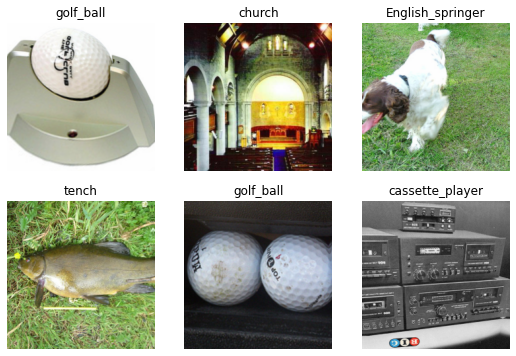

In [26]:
def get_data(url, presize, resize):
    return DataBlock(
                     blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
                     splitter=GrandparentSplitter(valid_name='val'),
                     get_y=get_y, item_tfms=Resize(presize),
                     batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                     Normalize.from_stats(*imagenet_stats)],
                    ).dataloaders(path, bs = 32)


dls = get_data(URLs.IMAGENETTE, 460, 224)
dls.show_batch(max_n=6)

In [7]:
print(f"Class Names: {dls.vocab}")
print(f"Train datapoints: {len(dls.train_ds)}, Valid datapoints: {len(dls.valid_ds)}")

Class Names: ['English_springer', 'French_horn', 'cassette_player', 'chain_saw', 'church', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute', 'tench']
Train datapoints: 9469, Valid datapoints: 3925


In [8]:
pd.DataFrame(Counter([parent_label(x) for x in dls.train_ds.items]), index = ['Train Counts'])

,n03394916,n03888257,n03425413,n02102040,n03417042,n02979186,n01440764,n03445777,n03000684,n03028079
Train Counts,956,960,931,955,961,993,963,951,858,941


In [9]:
pd.DataFrame(Counter([parent_label(x) for x in dls.valid_ds.items]), index = ['Valid Counts'])

,n03394916,n03888257,n03425413,n02102040,n03417042,n02979186,n01440764,n03445777,n03000684,n03028079
Valid Counts,394,390,419,395,389,357,387,399,386,409


So, we see that there are close to 1000 train and 400 validation images for each category meaning there's no class imbalance in our dataset. And also our data is pretty diverse that way in the sense there's substantial distance between the classes. With this information about our dataset, let's dive into creating a resnet architecture that could take in these images and classify them into one of these 4 categories.

# Building a resnet34 architecture from scratch

![](./images/resnet34.png)

In [10]:
class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, ks = 3, s = 1):
        super().__init__()
        
        p = ks // 2  # Padding will be half the kernel size
        first_stride = 2 if in_channels != out_channels else s  
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = ks, stride = first_stride, padding = p)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = ks, stride = s, padding = p)
        self.bn1, self.bn2 = nn.BatchNorm2d(out_channels), nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                                            nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 2),
                                            nn.BatchNorm2d(out_channels)
                                            )
        else:
            self.downsample = noop
        
    def forward(self, x):
        # Create a copy of the input
        original_input = copy(x)
        
        # First conv block forward pass
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Second block forward pass
        x = self.bn2(self.conv2(x))
        
        # Skip path output
        skip_connection = self.downsample(original_input)
        
        # Final output
        output = F.relu(x + skip_connection)
        return output

We build the architecture in blocks. One block is two convs (with bn and activation) accompanied with a skip connection and these blocks stack on top of one another. Except the blocks where there's downsampling i.e. spatial dimension is halved by taking a stride of 2 and number of feature maps are doubled, all other feature maps are same input same output type.

So, whenever we have a block which has differing feature maps as input/output, we have to explicitly downsample the input to be able to add the tensors and for that we use a (1 x 1) convolution with stride 2. Also we add a batchnorm to it for stability in training.

Then the forward pass is just the same as depicted in the skip connection diagram. We compute the residual path output, skip path output and add them, activate them and pass them into subsequent layers. This progression continues till we eventually get `512` feature maps and we aggregate them spatially to get a `512` length vector for all the variants of the resnet family.

In [11]:
class custom_resnet(nn.Module):
    
    def __init__(self, block_sizes, feature_map_sizes, classes):
        super().__init__()
        
        named_blocks = []
        for idx, (bs, fmap_size) in enumerate(zip(block_sizes, feature_map_sizes)):
            blocks = []
            for i in range(bs):
                if i == 0:
                    if idx == 0:
                        # Don't downsample first block of the first group
                        rblock = ResBlock(fmap_size, fmap_size)
                    else:
                        # Downsampling for the first block of every group
                        rblock = ResBlock(feature_map_sizes[idx - 1], fmap_size)
                else:
                    rblock = ResBlock(fmap_size, fmap_size)
                blocks.append(rblock)
            named_blocks.append((f"layer{idx + 1}", nn.Sequential(*blocks)))
        # Define the backbone of the architecture
        self.body = nn.Sequential(OrderedDict([
                                    ("conv1", nn.Conv2d(3, 64, kernel_size = 7, stride = 2)),
                                    ("bn1", nn.BatchNorm2d(64)),
                                    ("maxpool", nn.MaxPool2d(kernel_size = 3, stride = 2)),
                                    *named_blocks
                                   ]))
        
        # Define the head/classification layer of the architecture
        self.head = nn.Sequential(OrderedDict([
                                            ('avgpool',nn.AdaptiveAvgPool2d(output_size = (1, 1))),
                                            ('flatten',nn.Flatten()),
                                            ('fc',nn.Linear(in_features = feature_map_sizes[-1], out_features = classes)),
                                            ]))
            
    
    def forward(self, x):
        return self.head(self.body(x))

In [65]:
n = len(dls.vocab)
learn = Learner(dls, custom_resnet([2, 2, 2, 2], [64, 128, 256, 512], n), metrics = [accuracy])
learn.fine_tune(freeze_epochs = 3, epochs = 12, base_lr = 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.575022,1.842403,0.443567,02:43
1,1.433726,1.999339,0.417580,01:04
2,1.310581,1.156753,0.628025,01:04


epoch,train_loss,valid_loss,accuracy,time
0,0.950533,0.861086,0.720764,01:04
1,1.012109,0.954744,0.684586,01:05
2,0.949478,0.908305,0.701911,02:49
3,0.958813,1.329822,0.586497,01:05
4,0.922914,1.015200,0.669809,01:05
5,0.838644,0.773755,0.754650,01:05
6,0.731716,0.764956,0.751338,01:05
7,0.663952,0.663514,0.791338,01:05
8,0.608070,0.549461,0.824204,01:06
9,0.551718,0.528747,0.835924,01:06


We can see above that simply with a resnet18 model (not pretrained but from scratch), we can achieve as good an accuracy as imagenet on this smaller subset of 10 classes in just 15 epochs. Not bad at all! 

With the above block i.e. plain `ResBlock` we can construct `resnet18` and `resnet34`. However for creating `resnet50` we need a another kind of block called a `BottleneckBlock`. Let us see what this block is and how we could construct one.

![](./images/normal_vs_bottleneck.png)